## Custom training: walkthrough, Link2

Por:
- David Chaverra Munera
- Andres Aguilar
- Juan Felipe Múnera Vergara
- Freddy Castro Peralta

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import matplotlib.pyplot as plt

import tensorflow as tf
tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.13.1
Eager execution: True


The iris dataframe, find it in https://en.wikipedia.org/wiki/Iris_flower_data_set

In [2]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

(train_dataset_fp)

'C:\\Users\\JF_Mra\\.keras\\datasets\\iris_training.csv'

In [16]:
import qgrid
qqview = qgrid.show_grid(train_dataset_fp)
qqview

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [4]:
# column order in CSV file
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


Se hacen estos mapeos for species
- 0: Iris setosa
- 1: Iris versicolor
- 2: Iris virginica


In [26]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

Transformando la base de datos en un formato apropiado

In [11]:
batch_size = 240

train_dataset = tf.contrib.data.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

type(train_dataset)

tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter

In [12]:
features, labels = next(iter(train_dataset))

labels

<tf.Tensor: id=546, shape=(120,), dtype=int32, numpy=
array([0, 1, 2, 1, 0, 2, 1, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 2, 1, 0, 2, 0,
       2, 2, 1, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0,
       2, 1, 2, 1, 0, 0, 2, 0, 1, 0, 0, 1, 0, 2, 2, 1, 0, 1, 0, 0, 2, 1,
       1, 0, 1, 0, 2, 1, 2, 1, 1, 2, 2, 0, 0, 1, 0, 0, 0, 2, 0, 2, 2, 1,
       1, 2, 0, 0, 0, 1, 1, 2, 2, 1, 2, 0, 0, 1, 1, 2, 1, 2, 0, 2, 0, 0,
       1, 1, 1, 1, 1, 2, 1, 1, 0, 0])>

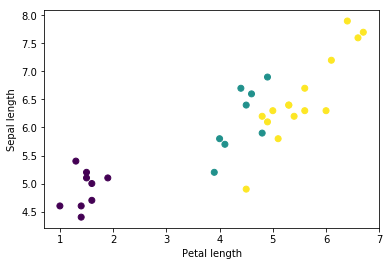

In [35]:
plt.scatter(features['petal_length'].numpy(),
            features['sepal_length'].numpy(),
            c=labels.numpy(),
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

In [36]:
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

In [37]:
train_dataset = train_dataset.map(pack_features_vector)

In [42]:
features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[5.  3.5 1.3 0.3]
 [4.8 3.1 1.6 0.2]
 [5.4 3.9 1.3 0.4]
 [5.4 3.9 1.7 0.4]
 [6.  3.  4.8 1.8]], shape=(5, 4), dtype=float32)


## Create a model using Keras

In [41]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

In [44]:
predictions = model(features)
predictions[:5]

<tf.Tensor: id=685, shape=(5, 3), dtype=float32, numpy=
array([[0.64462465, 1.9715564 , 1.6553231 ],
       [0.48485833, 1.8338295 , 1.4746605 ],
       [0.76882124, 2.129577  , 1.814602  ],
       [0.7515128 , 2.0326874 , 1.6983296 ],
       [0.6187084 , 1.2985239 , 0.6436136 ]], dtype=float32)>

In [45]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: id=700, shape=(5, 3), dtype=float32, numpy=
array([[0.13303214, 0.50145936, 0.3655084 ],
       [0.13255285, 0.51078695, 0.35666022],
       [0.1291196 , 0.5034552 , 0.36742523],
       [0.1393076 , 0.50162816, 0.3590642 ],
       [0.2500793 , 0.49353492, 0.25638577]], dtype=float32)>

In [46]:
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
    Labels: [0 0 0 0 2 2 2 1 0 0 2 1 0 2 1 0 1 1 0 0 1 2 0 2 2 0 0 2 2 0 0 2]


## Train the model

Our model will calculate its loss using the tf.keras.losses.categorical_crossentropy function 

In [49]:
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)


l = loss(model, features, labels)
print("Loss test: {}".format(l))

Loss test: 1.5798569917678833


In [50]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

## Create an optimizer

In [52]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

global_step = tf.Variable(0)

In [57]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(global_step.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables), global_step)

print("Step: {},         Loss: {}".format(global_step.numpy(),
                                          loss(model, features, labels).numpy()))

Step: 805, Initial Loss: 0.1922113448381424
Step: 806,         Loss: 0.1858786642551422


In [58]:
from tensorflow import contrib
tfe = contrib.eager

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables),
                              global_step)

    # Track progress
    epoch_loss_avg(loss_value)  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 0.185, Accuracy: 96.667%
Epoch 050: Loss: 0.138, Accuracy: 98.333%
Epoch 100: Loss: 0.118, Accuracy: 99.167%
Epoch 150: Loss: 0.103, Accuracy: 98.333%
Epoch 200: Loss: 0.085, Accuracy: 97.500%


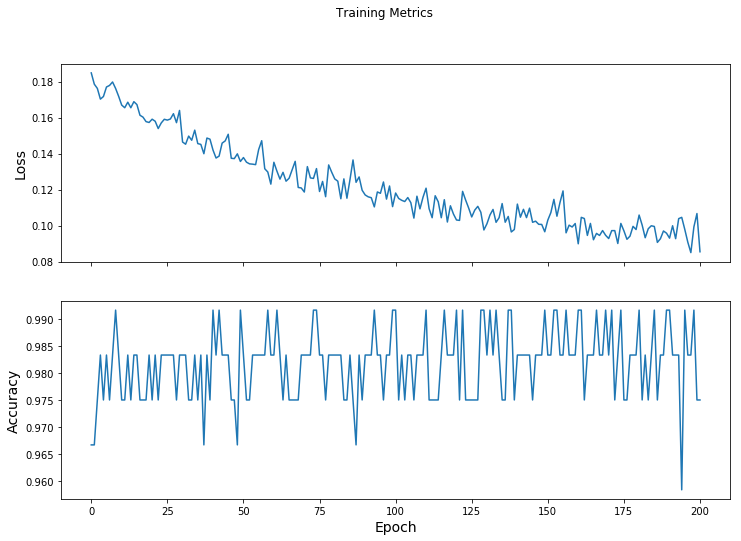

In [59]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

## Evaluate the model's effectiveness

In [60]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [61]:
test_dataset = tf.contrib.data.make_csv_dataset(
    test_fp,
    batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

## Evaluate the model on the test dataset

In [62]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
  logits = model(x)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%


In [65]:
tf.stack([y,prediction],axis=1)

<tf.Tensor: id=228990, shape=(30, 2), dtype=int32, numpy=
array([[1, 1],
       [2, 2],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [2, 2],
       [1, 1],
       [2, 2],
       [2, 2],
       [0, 0],
       [2, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1]])>

## Use the trained model to make predictions

In [66]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Iris setosa (98.8%)
Example 1 prediction: Iris versicolor (96.8%)
Example 2 prediction: Iris virginica (88.4%)
